# Make bboxes geo-aware

### Imports

In [1]:
from shapely.geometry import Polygon
from pyproj import Transformer
import folium

### Some setup 

In [2]:
origin_ = [19.958494700836596, 50.046781124380225] # [0,0] point, the beginning of the image -> top-left corner, can be lon/lat or easting/nortning the order (x, y) is important
transformer = Transformer.from_crs("epsg:4326", "epsg:2180",always_xy=True) # transfrormer from lat/lon to EPSG:2180
origin = transformer.transform(*origin_)
bbox = [[98, 345],[420, 462]] # top-left, bottom-right (in pixels)

In [3]:
def reverse_coords(point):
    return [point[1], point[0]]

In [4]:
f = folium.Figure(width=720, height=500)
m = folium.Map(location=reverse_coords(origin_), zoom_start=18).add_to(f)
folium.Marker(
    reverse_coords(origin_), popup="<i>Origin</i>", tooltip="Origin"
).add_to(m)
m

### How does it work?

So we are assuming a few things here. First we assume that you have some metadata from your files. We will need to know 2 things:
* The origin point
* Distance per pixel

The origin point is the (0,0) point of your image. The top-left point. We need to know it's coordinates. They can be either be 
easting/northing (in meters) or lon/lat (in degrees). 

The distance per pixel is also needed. It can be either in meters or in degrees. It's your job to ensure that the distance is 
in meters if your origin coordinates are easting/northing pair. If your origin's coordinates are in degrees, then you need to
ensure that the distance per pixel is in degrees as well.

The idea behind this algorithm is simple:
1. We take the origin point 
2. We create a proper polygon from bbox (4 points instead of 2)
3. For each point we add the distance multiplied by the coordinates of that point to the origin
4. Done


In [5]:
from typing import List

def to_poly(bbox):
    top_left = bbox[0]
    top_right = [bbox[1][0], bbox[0][1]]
    bottom_right = bbox[1]
    bottom_left = [bbox[0][0], bbox[1][1]]
    
    poly = [top_left, top_right, bottom_right, bottom_left]
    
    return poly

def geo_bbox(bbox:List[List[float]], origin: List[float], distance_per_pixel: float) -> List[List[float]]:
    """
    Maps specified bounding box (left-upper, bottom-right) in pixels to geo-encoded polygon in meters or degrees.
    
    Args:
        bbox (List[List[float]]): The bounding box (top-left & bottom-right). Has to be in following format: [[x, y], [x, y]].
        origin (List[float]): The origin coordinates. Top-left point (0,0) of your input image. 
        units_per_pixel (float): Units per pixel. How many degrees or meters is there per pixel.
        
    Returns:
        (List[List[float]]): A list of 4 points representing bounding box polygon that has been made geo.
    """
    poly = to_poly(bbox)
    
    output_poly = []
    origin_x, origin_y = origin
    for (x, y) in poly:
        x_hat = origin_x + distance_per_pixel * x
        y_hat = origin_y - distance_per_pixel * y
        output_poly.append([x_hat, y_hat])
        
    return output_poly

### Run conversion

[[98, 345], [420, 345], [420, 462], [98, 462]]
[[568614.4800091045, 242573.65476667695], [568646.6800091044, 242573.65476667695], [568646.6800091044, 242561.95476667694], [568614.4800091045, 242561.95476667694]]


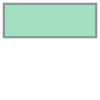

In [6]:
result = geo_bbox(bbox=bbox, origin=origin, distance_per_pixel=0.1)
print(to_poly(bbox))
print(result)
Polygon(result)

### Visualize results

In [7]:
import geopandas as gpd

transformer = Transformer.from_crs("epsg:2180", "epsg:4326",always_xy=True)
in_lat_lon = [transformer.transform(*point) for point in result]

f = folium.Figure(width=720, height=500)
m = folium.Map(location=reverse_coords(origin_), zoom_start=18).add_to(f)

folium.Marker(reverse_coords(origin_), popup="<i>Origin</i>", tooltip="Origin").add_to(m)

gdf = gpd.GeoDataFrame({"geometry": [Polygon(in_lat_lon)]}, crs="EPSG:4326")

folium.GeoJson(gdf).add_to(m)

m